# Análisis data set "Ratings_baby" de Amazon

Fuente: http://jmcauley.ucsd.edu/data/amazon/

### Introducción
El análisis se va a realizar con 2 datasets:
1. ratings_Baby: Contiene el consolidado de las comprar y la calificación
2. Baby_5.json: Contiene la descripción del cliente que lo compró

In [1]:
# Importación de las librerias
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
#import sys
import matplotlib.pyplot as plt

In [2]:
# Archivos y variables a usar
f_csv='ratings_Baby.csv'
f_json='Baby_5.json'
f_grupo_des = 'grupo_des.csv'
f_prod_most_voted = 'prod_most_voted.txt'
f_user_most_votation = 'user_most_votation.txt'
f_m_calificaciones_prod = 'matriz_calificaciones_productos.csv'
f_matriz_calificaciones_usuarios = 'matriz_calificaciones_usuarios.csv'
f_matriz_final_usu_prod = 'matriz_final_usu_prod.csv'

csv_names=['reviewerID','asin','overall','unixReviewTime']
filtro = ['reviewerID','asin','unixReviewTime','overall']
names_des=['reviewerID','asin','overall','unixReviewTime','helpful','reviewText','reviewTime','reviewerName','summary']
names_calificaciones=['1','2','3','4','5']

In [3]:
# Definición de metodos y funciones

# Importe dataset a un dataset (matriz)
# arg1-> matriz, t-> tipo archivo (csv, json), h-> cabecera (valor =! '')
# s_index-> establece la primer columna como index (valor=0)
def import_mat(arg1, t='csv', h='',s_index=0): 
    if t == 'csv':   
        if h == '':
            df_csv=pd.read_csv(arg1)
            h=head(arg1)
        else:
            names=h
            df_csv=pd.read_csv(arg1, names=h)
        if s_index == 0:
            for i in range(1): df_f=h[i]
            df_csv.set_index(df_f, inplace=True)
            del df_csv.index.name
    elif t == 'json':
        df_csv = pd.read_json(arg1, lines = True)
    return (df_csv)

# Obtención de la cabecera del archivo
def head(arg1,f=0):
    if f == 0:
        df_csv=pd.read_csv(arg1)
    else:
        df_csv=arg1
    h=list(df_csv.head(0))
    return h

# Promedio general matriz
def prom_gen(arg1, s_index=0):
    denominador=0
    numerador=0
    h=head(arg1,s_index)
    for i in range(len(arg1)):
        for j in range(len(h)-1):
            if arg1.iloc[i,j] >= 1:
                denominador=denominador +1
                numerador= numerador+arg1.iloc[i,j]
    prom_general=numerador/denominador
    return prom_general

# Promedios y sesgos por filas para la matriz
def prom_ses_fc(df_csv, t):
    if t == 'prom_fila':
        result = df_csv.mean(axis=1) 
    elif t == 'prom_col':
        result = df_csv.mean(axis=0)
    elif t == 'ses_fila':
        result = prom_general - df_csv.mean(axis=1)
    elif t == 'ses_col':
        result = prom_general - df_csv.mean(axis=0)
    return result

# Valida los números de la matriz
def val_matriz_num(m, s_index = 0):
    h=head(m, s_index)
    for i in range(len(df_csv)):
        for j in range(len(h)-1):
            if df_csv.iloc[i,j] >= 1:
                #print(df_csv.iloc[i,j])
                pd.to_numeric(df_csv.iloc[i,j])
    return

# Matriz de linea base
def m_baseline(df_predict,df_prom_fila,prom_general, ses_fila, ses_col):
    #df_predict=df_csv
    h=head(df_csv,1)
    for i in range(len(df_prom_fila)):
        for j in range(len(h)):
            suma=prom_general+ses_fila.iloc[i]+ses_col.iloc[j]
            if suma > 5: suma=5
            df_predict.iloc[i,j]=suma
    return df_predict

# Matriz de diferencia
def m_dif(df_err, df_predict,s_index =0):
    s_index =1
    h=head(df_err, s_index)
    for i in range(len(df_err)):
        for j in range(len(h)):
            resta=df_err.iloc[i,j]-df_predict.iloc[i,j]
            #print(resta)
            if resta > 5: resta=5
            df_err.iloc[i,j]=resta
    return df_err

# Total usuarios sin duplicados
def cal_cantidad(df='',campo='',resta=0):
    if resta == 0:
        return len(df.groupby([campo]).size().sort_values(ascending=False))
    else:
        return len(df.groupby([campo]).size().sort_values(ascending=False))-resta

# Promedio Ponderado
# m -> matriz, c -> nombre del objeto, s_index -> para establecer el index
def prom_pond(m, c='Objeto', s_index = 0):
    suma_fila=0
    suma_usua=0
    prom_pond =0
    l_prom_pond=[]
    for i in range(len(m)):
        for j in range(len(head(m, 1))-1):
            suma_fila=suma_fila+(m.iloc[i,j]*(j+1))
            suma_usua = suma_usua+m.iloc[i,j]
        prom_pond = suma_fila/suma_usua
        l_prom_pond.append((m.index[i], prom_pond))
    result= pd.DataFrame(l_prom_pond, columns=(c,'PromedioPonderado'))
    h=list(result.head(0))
    if s_index == 0:
        for i in range(1): df_f=h[i]
        result.set_index(df_f, inplace=True)
        del result.index.name
    return result

In [4]:
# Se importa el primer dataset y se le asignan las cabeceras para poder identificarlos después
df_csv=import_mat(f_csv,'csv',csv_names,1)
# Se imprime el primer dataset importado
#df_csv

In [5]:
# Se importa el segundo dataset que se encuentra en formato json
df_json=import_mat(f_json,'json')
# Se imprime el segundo dataset importado
#df_json

In [6]:
# Se filtra para usar exclusivamente clientes identificados en la bd
df_grp = pd.merge(df_csv, df_json, how='inner', on= filtro)#.set_index(["reviewerID","asin","unixReviewTime"])
# Para generar nuevo archivo filtrado
#df_grp.to_csv('df_grp.txt',sep='®', index=False, header=True)
#df_grp

# Archivo con la fecha correcta y filtrado desde el 2010
df_csv_n= import_mat(f_grupo_des,'csv',names_des,1)
#df_csv_n

# Agregada por Cris
#df = df_grp.pivot(index='reviewerName', columns='asin', values='overall')
#df

In [7]:
# Total productos sin duplicados
pro_ori = cal_cantidad(df_grp,'asin')
pro_mod = cal_cantidad(df_csv_n,'asin')
usu_ori = cal_cantidad(df_grp,'reviewerName',1)
usu_mod = cal_cantidad(df_csv_n,'reviewerName',1)

print("Cantidad productos doc original: ",pro_ori)
print("Cantidad productos doc modificado: ",pro_mod)
print("\nCantidad usuarios doc original: ",usu_ori)
print("Cantidad usuarios doc modificado: ",usu_mod)


Cantidad productos doc original:  7050
Cantidad productos doc modificado:  6880

Cantidad usuarios doc original:  17176
Cantidad usuarios doc modificado:  16511


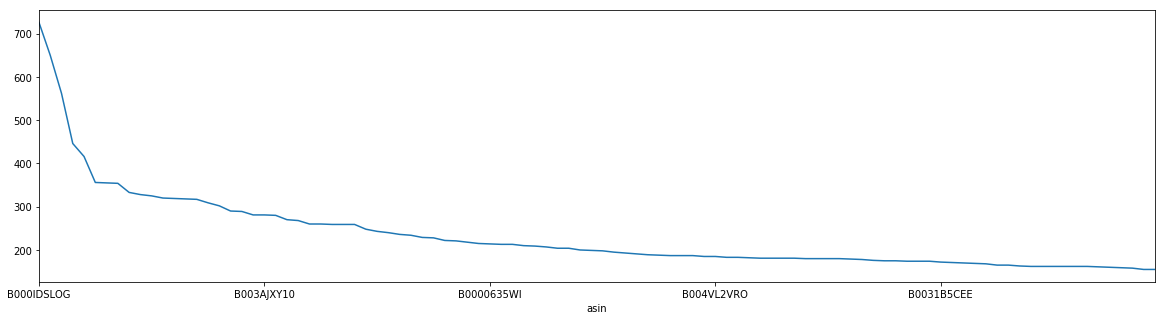

asin
B000IDSLOG    726
B00295MQLU    650
B000YDDF6O    562
B001U9OUYC    446
B0000DEW8N    416
B0042D69WY    356
B000LXQVA4    355
B000LSL5ZK    354
B001DVRTEA    333
B000GJIE4E    328
B001WAJVZM    325
B0045I6IA4    320
B0013FGWD0    319
B001AG0YL8    318
B0034UGFB6    317
B000S9RF4M    309
B0012AII9M    302
B0052QYLUM    290
B000BNQC58    289
B000I2Q0F4    281
B003AJXY10    281
B006ZVV0NO    280
B002MN3JY2    270
B002QYW8LW    268
B006SFUEF2    260
B001UF8BL4    260
B0038JDVBK    259
B001BMWABI    259
B000K53UEI    259
B002US8D5Y    248
             ... 
B003U6HCGQ    180
B000GKWA66    180
B004W93MFK    179
B0067GKGFU    178
B004G8QSYO    176
B001I481LM    175
B000GB0NZK    175
B000GK5XY2    174
B00078ZHPS    174
B004L2JJAK    174
B0031B5CEE    172
B001GQ2SA2    171
B005OI8O88    170
B0016KV73W    169
B0045VA3SO    168
B0007CS4EU    165
B003AJHDQW    165
B00834D5SO    163
B001KZH692    162
B003FPQKYW    162
B001O9F6M8    162
B000CP2X9O    162
B000GOUUR8    162
B003807VGK    162
B001Q

In [8]:
# Top Productos del más votado al menos votado
#prod_most_voted=df_grp.groupby(['asin']).size().sort_values(ascending=False)#.head(150)
prod_most_voted=df_csv_n.groupby(['asin']).size().sort_values(ascending=False).head(100)
#prod_most_voted.to_csv(f_prod_most_voted, sep=' ', index=True, header=False)
prod_most_voted.plot(legend=False, figsize=(20,5))
plt.show()
prod_most_voted
### validar si el más calificado es el mejor votado

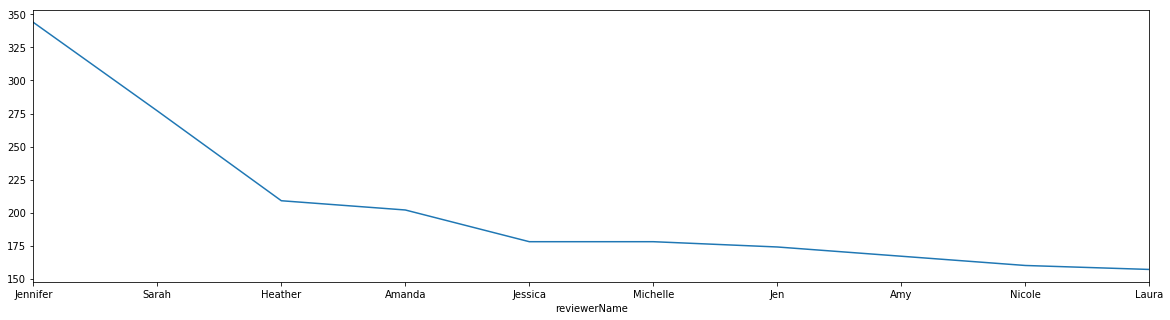

reviewerName
Jennifer    344
Sarah       277
Heather     209
Amanda      202
Jessica     178
Michelle    178
Jen         174
Amy         167
Nicole      160
Laura       157
dtype: int64

In [9]:
# Top Usuarios que más votan - limpiado
#user_most_votation_or=df_grp.groupby(['reviewerName']).size().sort_values(ascending=False).head(10)
user_most_votation=df_csv_n.groupby(['reviewerName']).size().sort_values(ascending=False).head(11)
#user_most_votation.to_csv(f_user_most_votation,sep=' ', index=True, header=False)
user_most_votation.drop(user_most_votation.index[0], inplace=True)
user_most_votation.plot(legend=False, figsize=(20,5))
plt.show()
user_most_votation
## Validar que tipo de calificación tiene el que más vota

In [10]:
# Filtro por producto
#df_grp.query('asin == \'B000IDSLOG\'')

In [11]:
# Filtro por usuario
#df_grp.query('reviewerName == \'Jennifer\'')

Fecha mínima:  2010-01-01
Fecha máxima:  2014-07-22


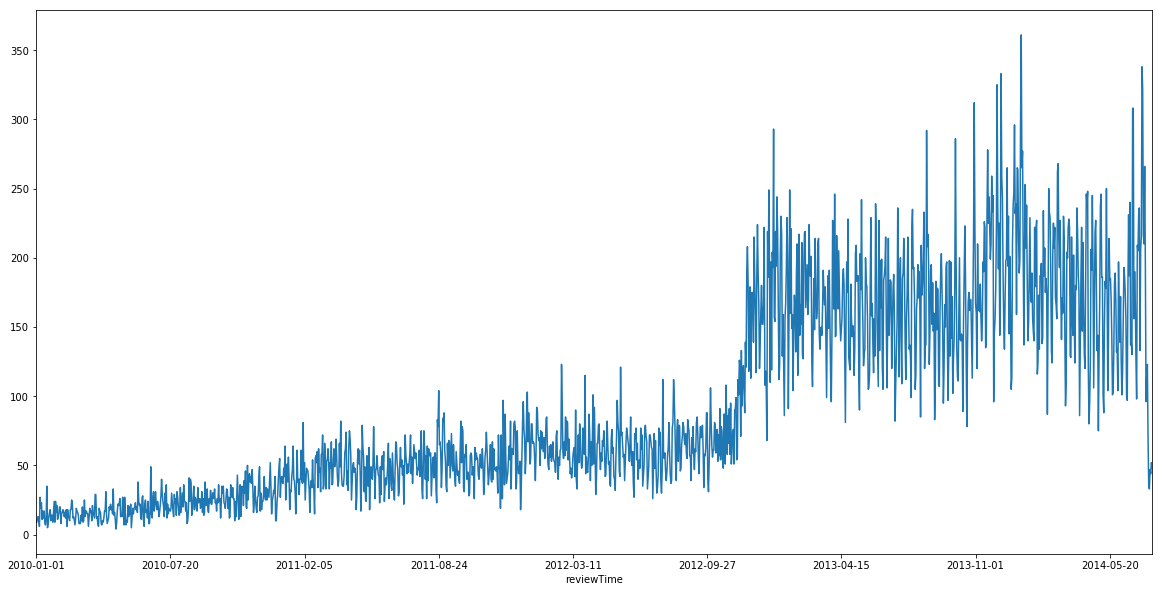

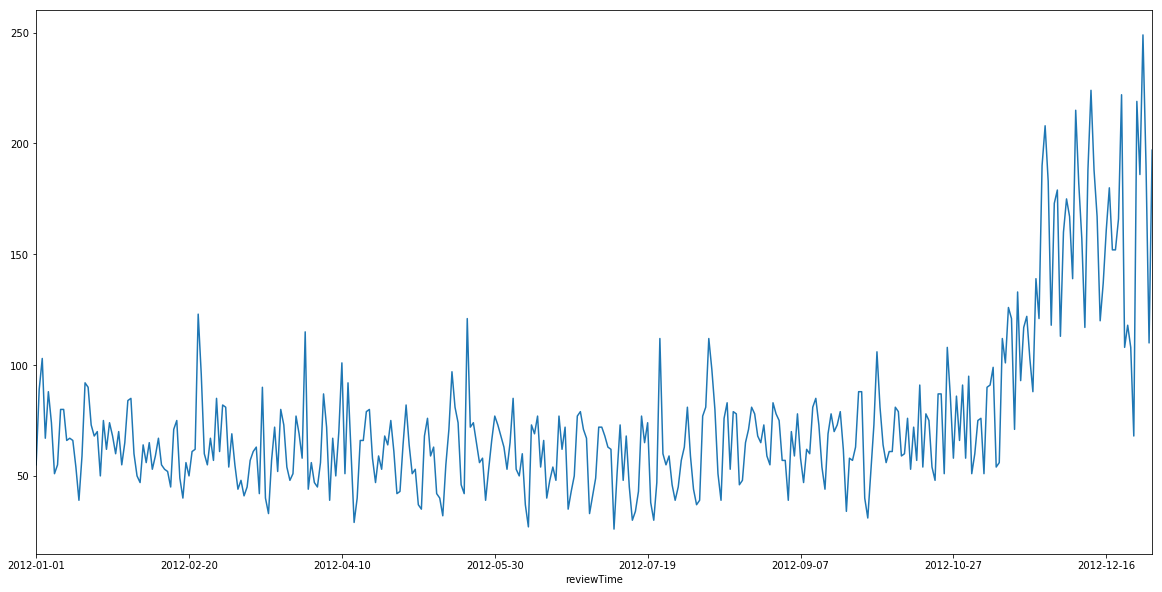

In [12]:
df_csv_n.drop(df_csv_n.index[0], inplace=True)
print("Fecha mínima: ",min(df_csv_n.reviewTime))
print("Fecha máxima: ",max(df_csv_n.reviewTime))
df_csv_n.groupby(['reviewTime']).size().sort_index().plot(legend=False, figsize=(20,10))
#df_csv_n.groupby(['reviewTime']).size().sort_values(ascending=False)#.head(150)
plt.show()

df_csv_n.groupby(['reviewTime']).size().sort_index().filter(like='2012', axis=0).plot(legend=False, figsize=(20,10))
plt.show()

In [13]:
# matriz_calificaciones_productos
matriz_calificaciones_productos = import_mat(f_m_calificaciones_prod, 'csv')
prom_pond_productos = prom_pond(matriz_calificaciones_productos,'Productos')
prom_pond_productos

,PromedioPonderado
B003XMWFB4,2.250000
B003Y53YR4,2.526316
B003YC0W7W,2.607143
B003YC0W8G,2.694444
B003YDWU2Q,2.723404
B003YHUVH8,2.648148
B003YNL6M6,2.672131
B003YV3S1A,2.656716
B003YVHXAW,2.675325
B003ZFPRHS,2.644444


In [14]:
# matriz_calificaciones_usuarios
matriz_calificaciones_usuarios = import_mat(f_matriz_calificaciones_usuarios, 'csv')
prom_pond_usuarios = prom_pond(matriz_calificaciones_usuarios,'Usuarios')
prom_pond_usuarios

,PromedioPonderado
"Paige ""Paige In A Book""",2.500000
"Penelope ""internet shoppy""",2.500000
"Primatebuddy ""hcmitche""",2.538462
"Private ""private31""",2.400000
"R. D. Williams ""RDavidW""",2.440000
"R. Ocampo ""Artisan""",2.558824
"Rachel H ""Bon Vivant""",2.452381
"Rachel McCulloch ""Mom, Wife, Blogger, World T...\t1\t1\t1\t2\t3\r\nRoberta T. Clemens """"sfgrl""""""",2.469388
"Rolling Root ""Rolling Root""",2.471698
"S. Day ""LoveinLight""",2.473684


In [15]:
matriz_calificaciones_usuarios = import_mat(f_matriz_calificaciones_usuarios, 'csv')
matriz_calificaciones_usuarios

,1,2,3,4,5
"Paige ""Paige In A Book""",1,1,1,1,2
"Penelope ""internet shoppy""",1,1,1,1,2
"Primatebuddy ""hcmitche""",1,1,2,1,1
"Private ""private31""",3,1,2,1,3
"R. D. Williams ""RDavidW""",1,1,2,1,2
"R. Ocampo ""Artisan""",1,2,3,3,1
"Rachel H ""Bon Vivant""",3,3,1,1,3
"Rachel McCulloch ""Mom, Wife, Blogger, World T...\t1\t1\t1\t2\t3\r\nRoberta T. Clemens """"sfgrl""""""",1,3,1,2,2
"Rolling Root ""Rolling Root""",1,1,1,1,1
"S. Day ""LoveinLight""",1,1,1,1,2


In [16]:
df_csv=import_mat(f_matriz_final_usu_prod)
val_matriz_num(df_csv,1)
df_csv

,B000056J7K,097293751X,B000056J78,B00005U8T5,9729375011,B000058DN6
"A. Clapprood ""Alex""",5.0,NaN,NaN,NaN,NaN,NaN
"A. Hua ""Engineer and Psychologist - Tech and ...\t5.0\tNULL\tNULL\tNULL\tNULL\tNULL\r\nA. John """"military mom""""""",5.0,NaN,NaN,NaN,NaN,NaN
"Amanda Johnsen ""Amanda E. Johnsen""",NaN,5.0,NaN,NaN,NaN,NaN
"MidwestMommy ""Vicky""",NaN,NaN,5.0,NaN,NaN,NaN
"R. Davidson ""Jrdpa""",NaN,3.0,NaN,NaN,NaN,NaN
"Ronindoc ""Ronindoc""",NaN,NaN,NaN,5.0,NaN,NaN
"S. Pedersen ""Book, Bath & Bed.. wind me down!""",NaN,NaN,NaN,5.0,NaN,NaN
"SafeT ""Troy""",NaN,NaN,NaN,4.0,NaN,NaN
AJH,5.0,NaN,NaN,NaN,NaN,NaN
albanoch,5.0,NaN,NaN,NaN,NaN,NaN


In [17]:
# Creación de promedios

# Promedio general
prom_general=prom_gen(df_csv,1)
# Promedio filas y columnas 
df_prom_fila= prom_ses_fc(df_csv,'prom_fila')
df_prom_col= prom_ses_fc(df_csv,'prom_col')
# Sesgos filas y columnas 
ses_fila = prom_ses_fc(df_csv,'ses_fila')
ses_col = prom_ses_fc(df_csv,'ses_col')

print("Promedio General\n",prom_general,'\n')
print("Promedio Columnas\n",df_prom_col,'\n')
print("Promedio Filas\n",df_prom_fila,'\n')
print("Sesgo Filas\n",ses_fila,'\n')
print("Sesgo Columnas\n",ses_col,'\n')

Promedio General
 4.38095238095 

Promedio Columnas
 B000056J7K    5.000000
097293751X    4.466667
B000056J78    4.857143
B00005U8T5    3.300000
9729375011    5.000000
B000058DN6    4.800000
dtype: float64 

Promedio Filas
 A. Clapprood "Alex"                                                                                                 5.0
A. Hua "Engineer and Psychologist - Tech and ...\t5.0\tNULL\tNULL\tNULL\tNULL\tNULL\r\nA. John ""military mom"""    5.0
Amanda Johnsen "Amanda E. Johnsen"                                                                                  5.0
MidwestMommy "Vicky"                                                                                                5.0
R. Davidson "Jrdpa"                                                                                                 3.0
Ronindoc "Ronindoc"                                                                                                 5.0
S. Pedersen "Book, Bath & Bed.. wind me down!"          

In [18]:
# Matriz de linea base
df_predict=m_baseline(df_csv,df_prom_fila,prom_general, ses_fila, ses_col)
#print("Matriz BaseLine\n",df_predict)
df_predict

,B000056J7K,097293751X,B000056J78,B00005U8T5,9729375011,B000058DN6
"A. Clapprood ""Alex""",3.142857,3.67619,3.285714,4.842857,3.142857,3.342857
"A. Hua ""Engineer and Psychologist - Tech and ...\t5.0\tNULL\tNULL\tNULL\tNULL\tNULL\r\nA. John """"military mom""""""",3.142857,3.67619,3.285714,4.842857,3.142857,3.342857
"Amanda Johnsen ""Amanda E. Johnsen""",3.142857,3.67619,3.285714,4.842857,3.142857,3.342857
"MidwestMommy ""Vicky""",3.142857,3.67619,3.285714,4.842857,3.142857,3.342857
"R. Davidson ""Jrdpa""",5.000000,5.00000,5.000000,5.000000,5.000000,5.000000
"Ronindoc ""Ronindoc""",3.142857,3.67619,3.285714,4.842857,3.142857,3.342857
"S. Pedersen ""Book, Bath & Bed.. wind me down!""",3.142857,3.67619,3.285714,4.842857,3.142857,3.342857
"SafeT ""Troy""",4.142857,4.67619,4.285714,5.000000,4.142857,4.342857
AJH,3.142857,3.67619,3.285714,4.842857,3.142857,3.342857
albanoch,3.142857,3.67619,3.285714,4.842857,3.142857,3.342857


In [19]:
# Matriz de diferencias
# Se usará para calculos posteriores
df_err=import_mat(f_matriz_final_usu_prod)
df_err=m_dif(df_err, df_predict)
df_err

,B000056J7K,097293751X,B000056J78,B00005U8T5,9729375011,B000058DN6
"A. Clapprood ""Alex""",1.857143,NaN,NaN,NaN,NaN,NaN
"A. Hua ""Engineer and Psychologist - Tech and ...\t5.0\tNULL\tNULL\tNULL\tNULL\tNULL\r\nA. John """"military mom""""""",1.857143,NaN,NaN,NaN,NaN,NaN
"Amanda Johnsen ""Amanda E. Johnsen""",NaN,1.32381,NaN,NaN,NaN,NaN
"MidwestMommy ""Vicky""",NaN,NaN,1.714286,NaN,NaN,NaN
"R. Davidson ""Jrdpa""",NaN,-2.00000,NaN,NaN,NaN,NaN
"Ronindoc ""Ronindoc""",NaN,NaN,NaN,0.157143,NaN,NaN
"S. Pedersen ""Book, Bath & Bed.. wind me down!""",NaN,NaN,NaN,0.157143,NaN,NaN
"SafeT ""Troy""",NaN,NaN,NaN,-1.000000,NaN,NaN
AJH,1.857143,NaN,NaN,NaN,NaN,NaN
albanoch,1.857143,NaN,NaN,NaN,NaN,NaN
